In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Each task is encapsulated in a separate function, and these functions are called sequentially within the main function.


In [17]:
# Loading the datasets
def load_data():
    train = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv')
    test = pd.read_csv('/kaggle/input/santander-customer-satisfaction/test.csv')
    return train, test

    
    Performing exploratory data analysis (EDA) on the training dataset.
    - Analyzes class distribution for potential class imbalance.
    - Identifies features with zero variance as irrelevant.
    - Calculates correlation of features with the target variable.
    - Visualizes the distribution of top features with respect to the target.
   

In [22]:
def perform_eda(train_df):
        # Check for missing values
    missing_values = train_df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print("\nColumns with missing values:")
        print(missing_values)
    else:
        print("\nNo missing values found in the dataset.")
    # Check class distribution
    print("\nClass Distribution:")
    print(train_df['TARGET'].value_counts(normalize=True))
    
    # Calculate variance for all features
    variances = train_df.var()

    # Find zero-variance features (irrelevant)
    zero_var_features = variances[variances == 0].index.tolist()
    print(f"\nFeatures with zero variance (irrelevant): {zero_var_features[:3]}")
    
    # Feature importance based on correlation with target
    correlations = train_df.corr()['TARGET'].sort_values(ascending=False)
    print("\nTop 3 most relevant features based on correlation:")
    print(correlations[1:4])  # Excluding TARGET itself
    
    # Visualize distributions of top features
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(correlations[1:4].index):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x='TARGET', y=feature, data=train_df)
        plt.title(f'{feature} vs TARGET')
    plt.tight_layout()
    plt.show()
    
    return zero_var_features, correlations




   ## Training multiple Decision Tree models with different configurations and evaluates       them.
    - Configurations include various depth, split criteria, and impurity measures.
    - Calculates AUC score on training and validation datasets for each model.
    - Returns a DataFrame summarizing model performance.

In [19]:
# 3. Model Building and Training
def train_decision_tree_models(X_train, X_val, y_train, y_val):

    print("\nTraining different decision tree models...")
    
    # Model configurations to try
    configs = [
        {"name": "Default", "params": {}},
        {"name": "Deep Tree", "params": {"max_depth": 10, "min_samples_split": 5}},
        {"name": "Gini Tree", "params": {"criterion": "gini", "max_depth": 8}},
        {"name": "Entropy Tree", "params": {"criterion": "entropy", "max_depth": 8}}
    ]
    
    # Listed to store trained models with their names
    trained_models = []
    
    for config in configs:
        model_name = config['name']
        print(f"\nTraining {model_name} model...")
        
        # Initialized and trained the model
        model = DecisionTreeClassifier(**config['params'], random_state=42)
        model.fit(X_train, y_train)
        
        # Append the trained model and its name to the list
        trained_models.append((model_name, model))
    
    return trained_models


## Generated a CSV file for all the model and submitting it to kaggle

In [20]:
def generate_submission_for_models(trained_models, test_df, features):
    
    for model_name, model in trained_models:
        print(f"\nGenerating submission for {model_name}...")
        
        # Predicting probabilities for the test dataset
        predictions = model.predict_proba(test_df[features])[:, 1]
        
        # Creating a submission DataFrame
        submission = pd.DataFrame({
            'ID': test_df['ID'],
            'TARGET': predictions
        })
        
        # Saved the submission file with a unique name for each model
        submission_filename = f"{model_name}_submission.csv"
        submission.to_csv(submission_filename, index=False)
        print(f"Submission file saved as {submission_filename}")

## calling all the functions


No missing values found in the dataset.

Class Distribution:
TARGET
0    0.960431
1    0.039569
Name: proportion, dtype: float64

Features with zero variance (irrelevant): ['ind_var2_0', 'ind_var2', 'ind_var27_0']

Top 3 most relevant features based on correlation:
var36         0.102919
var15         0.101322
ind_var8_0    0.046665
Name: TARGET, dtype: float64


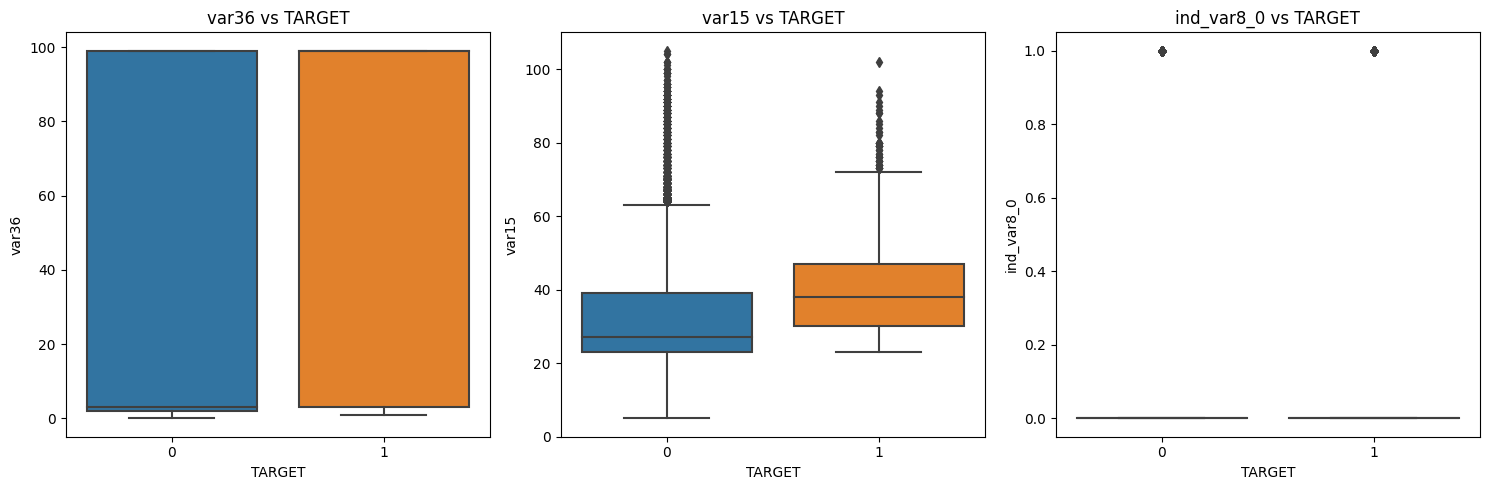


Training different decision tree models...

Training Default model...

Training Deep Tree model...

Training Gini Tree model...

Training Entropy Tree model...

Generating submission for Default...
Submission file saved as Default_submission.csv

Generating submission for Deep Tree...
Submission file saved as Deep Tree_submission.csv

Generating submission for Gini Tree...
Submission file saved as Gini Tree_submission.csv

Generating submission for Entropy Tree...
Submission file saved as Entropy Tree_submission.csv


In [23]:
def main():
    
    # Load data
    train_df, test_df = load_data()
    
    # Perform EDA, including missing values check
    zero_var_features, correlations = perform_eda(train_df)
    
    # Remove ID and irrelevant features from the feature set
    features = [col for col in train_df.columns 
                if col not in ['ID', 'TARGET'] + zero_var_features]
    
    # Split data into training and validation sets
    X = train_df[features]
    y = train_df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train decision tree models with different configurations
    trained_models = train_decision_tree_models(X_train, X_val, y_train, y_val)
    
    # Generate submission files for each trained model
    generate_submission_for_models(trained_models, test_df, features)

# Run the main function
if __name__ == "__main__":
    main()